# Smart Citizen - sensores electrónicos fijos de monitoreo de la calidad del aire

Este notebook muestra el proceso que se sigue para trabajar con los datos de los sensores electrónicos móviles de [Smart Citizen](https://smartcitizen.me/kits/). Los datos con los que se trabaja fueron recopilados del portal de la api de Plume, verificados y procesados, y actualmente se encuentran guardados en la base de datos del proyecto [Prototipos de Infraestructura Pública para una Ciudad del Futuro](https://pipciudadfuturo.com/).

El notebook consta de las siguientes partes:

+ Librerías utilizadas
+ Descarga de datos
+ Análisis básicos y filtrado de datos
+ Visualización de datos
+ Guardado de datos

## Librerías

Para interactuar con la base de datos y generar el procesmiento de los diferentes datos hemos desarrollado una librería propia `aqiGDL` que almacena las diferentes funciones que son requeridas para el trabajo. Además de la librería desarrollada por [LAC](https://lac.mx) para el proyecto, también se utilizan otras librerías de python para el análisis y visualización de datos.

In [ ]:
import os
import sys
import osmnx as ox
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aqiGDL
%matplotlib inline


#graph
import datetime
import textwrap

### Estilos visuales
Utilizamos el estilo visual "Pitaya Smoothie" para la generación de gráficas.

In [ ]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
colors = ['7A76C2', 'ff6e9c98', 'f62196', '18c0c4', 'f3907e', '66E9EC']

## Descarga de datos

### Datos históricos de calidad del aire registrados por los sensores

Los datos históricos de exposición a contaminantes atmosféricos durante desplazamientos han sido descargados desde la api de Smart Citizen. Actualmente los datos están disponibles desde la base de datos de PIP.

In [ ]:
gdf = aqiGDL.gdf_from_db('smartcitizen', 'public')
gdf

device_id                                              param unit  \
0           13483  Total Volatile Organic Compounds Digital Indoo...  ppb   
1           13483  Total Volatile Organic Compounds Digital Indoo...  ppb   
2           13483  Total Volatile Organic Compounds Digital Indoo...  ppb   
3           13483  Total Volatile Organic Compounds Digital Indoo...  ppb   
4           13483  Total Volatile Organic Compounds Digital Indoo...  ppb   
...           ...                                                ...  ...   
277281      13772                                        Temperature   ºC   
277282      13772                                        Temperature   ºC   
277283      13772                                        Temperature   ºC   
277284      13772                                        Temperature   ºC   
277285      13772                                        Temperature   ºC   

               lon        lat                  date         value  \
0      -103.351588  20.685147  2021-03-03T15:00:38Z  23628.451613   
1      -103.351588  20.685147  2021-03-03T14:00:08Z  29206.000000   
2      -103.351588  20.685147  2021-03-03T13:00:51Z  29206.000000   
3      -103.351588  20.685147  2021-03-03T12:00:49Z  29206.000000   
4      -103.351588  20.685147  2021-03-03T11:00:50Z  29206.000000   
...            ...        ...                   ...           ...   
277281 -103.413618  20.668877  2021-02-21T01:00:32Z     19.480167   
277282 -103.413618  20.668877  2021-02-21T00:00:26Z     19.575833   
277283 -103.413618  20.668877  2021-02-20T23:00:16Z     19.710333   
277284 -103.413618  20.668877  2021-02-20T22:00:12Z     19.777000   
277285 -103.413618  20.668877  2021-02-20T21:42:12Z     20.034444   

                              geometry  
0       POINT (671692.111 2288175.175)  
1       POINT (671692.111 2288175.175)  
2       POINT (671692.111 2288175.175)  
3       POINT (671692.111 2288175.175)  
4       POINT (671692.111 2288175.175)  
...                                ...  
277281  POINT (665247.641 2286309.678)  
277282  POINT (665247.641 2286309.678)  
277283  POINT (665247.641 2286309.678)  
277284  POINT (665247.641 2286309.678)  
277285  POINT (665247.641 2286309.678)  

[277286 rows x 8 columns]

### Red vial de Guadalajara

Con [OSMnx](https://osmnx.readthedocs.io/en/stable/) se descarga la red vial para el área de los sensores

In [ ]:
G = ox.graph_from_bbox(20.7900,20.523110,-103.2400,-103.4700)
edges = ox.graph_to_gdfs(G, nodes=False)

## Análisis básicos y filtrado de datos

### GeoDataFrame con ubicación de sensores

A partir de la tabla que se encuentra en la base de datos de PIP podemos hacer una agrupación por identificador del dispositivo de medición, al agrupar esta obtenemos las coordenadas de cada dispositivo. Al guardar estos datos en una nueva tabla podemos acceder a las ubicacioens más adelante.

In [ ]:
gdf_est = gdf[['device_id','lon','lat']].groupby('device_id').mean()
gdf_est = gpd.GeoDataFrame(
    gdf_est, geometry=gpd.points_from_xy(gdf_est.lon, gdf_est.lat))
gdf_est.head(2)

lon        lat                     geometry
device_id                                                    
13483     -103.351588  20.685147  POINT (-103.35159 20.68515)
13492     -103.389891  20.651647  POINT (-103.38989 20.65165)

### Información de contaminantes por registro

Desde nuestra tabla original, y utilizando el argumento unique, podemos observar cuales son los parámetros que los sensores de Smart Citizen están registrando para cada ubicación. Estos los vamos a utilizar más adelante para graficar el comportamiento de la contaminación en distintos puntos.

In [ ]:
gdf['param'].unique()

array(['Total Volatile Organic Compounds Digital Indoor Sensor',
       'Equivalent Carbon Dioxide Digital Indoor Sensor',
       'Digital Ambient Light Sensor', 'Custom Circuit',
       'I2S Digital Mems Microphone with custom Audio Processing Algorithm',
       'Digital Barometric Pressure Sensor', 'Particle Matter PM 1',
       'Particle Matter PM 10', 'Particle Matter PM 2.5', 'Humidity',
       'Temperature'], dtype=object)

### Dispositivos disponibles

De igual forma, con unique, podemos ver todos los identificadores de djispositivos que tenemos disponibles para consultas.

In [ ]:
gdf.device_id.unique()

array([13483, 13492, 13507, 13545, 13548, 13573, 13574, 13598, 13647,
       13689, 13702, 13771, 13772])

### Filtrado de datos por parámetro y dispositivo

Podemos hacer una prueba de filtrado de los datos de nuestra tabla original utilizando como filtro uno de los parámetros y de los identificadores de los dispositivos. En este caso vamos a utilizar los compuestos orgánicos volátiles para el dispositivo 13483.

In [ ]:
gdf_param = gdf.loc[(gdf.param=='Total Volatile Organic Compounds Digital Indoor Sensor')&(gdf.device_id==13483)]
gdf_param.head(2)

device_id                                              param unit  \
0      13483  Total Volatile Organic Compounds Digital Indoo...  ppb   
1      13483  Total Volatile Organic Compounds Digital Indoo...  ppb   

          lon        lat                  date         value  \
0 -103.351588  20.685147  2021-03-03T15:00:38Z  23628.451613   
1 -103.351588  20.685147  2021-03-03T14:00:08Z  29206.000000   

                         geometry  
0  POINT (671692.111 2288175.175)  
1  POINT (671692.111 2288175.175)

### Manejo de fechas

Debido a que las fechas tienen una mayor resolución temporal de la que necesitamos, vamos a hacer un tratamiento de datos para que queden agrupados por día y nos muestre los promedios diarios de concentración.

In [ ]:
pd.options.mode.chained_assignment = None
gdf_param['date'] = pd.to_datetime(gdf_param['date'])
gdf_param.set_index('date',inplace=True)
gdf_param = gdf_param.resample('D').mean()
gdf_param.head(2)

device_id         lon        lat         value
date                                                                     
2021-01-20 00:00:00+00:00      13483 -103.351588  20.685147   5225.986176
2021-01-21 00:00:00+00:00      13483 -103.351588  20.685147  12431.568545

Además, podemos visualizar distintas agrupaciones de los datos utilizando "rolling", que nos permite hacer promedios móviles en ventanas específicas. En este caso, vamos a seleccionar promedios cada tercer día. Es posible observar que los primeros dos valores no tienen datos debido a que no cumplen con el valor mínimo establecido de 3.

In [ ]:
gdf_param.rolling(3).mean().head(5)

device_id         lon        lat         value
date                                                                     
2021-01-20 00:00:00+00:00        NaN         NaN        NaN           NaN
2021-01-21 00:00:00+00:00        NaN         NaN        NaN           NaN
2021-01-22 00:00:00+00:00    13483.0 -103.351588  20.685147   7519.995688
2021-01-23 00:00:00+00:00    13483.0 -103.351588  20.685147   9804.676416
2021-01-24 00:00:00+00:00    13483.0 -103.351588  20.685147  10744.771708

### Primera visualización básica

Con los datos de fecha y de concentración en gdf_param podemos hacer una visualización rápida en la que tenemos en las "y" las concentraciones de compuestos orgánicos volátiles y en "x" nuestras fechas por día.

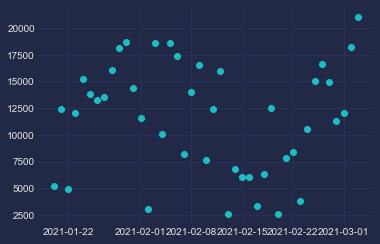

In [ ]:
plt.scatter(gdf_param.index, gdf_param['value'])

## Visualización de datos

Para hacer visualizaciones más avanzadas podemos utilizar la siguiente función (graph_smartcitizen), en la que tenemos como datos de entrada el número de dispositivo (device), el parámetro de interés (param), el GeoDataFrame descargado directamente de la base de datos de PIP (gdf), el GeoDataFrame que creamos previamente para las estaciones (gdf_est) y las vialidades descargadas de OSMnx (edges). Además, podemos determinar si queremos que la gráfica resultante se guarde (save).

In [ ]:
def graph_smartcitizen(device, param, gdf, gdf_est, edges, save=False):

    fig, axes = plt.subplots(1,2,figsize=(24,8), sharex=True)

    df_temp = gdf[(gdf['device_id']==device) & (gdf['param']==param)].copy()
    df_temp['date'] = pd.to_datetime(df_temp['date'])
    df_temp.set_index('date',inplace=True)
    df_temp = df_temp.resample('D').mean()
    axes[1].scatter(df_temp.index, df_temp['value'], label=param)

    title = textwrap.fill(param, 35)
    axes[1].set_title(title,fontsize=20)
    axes[1].tick_params(axis='x',labelrotation=45)


    x_ticks = np.arange(0, len(df_temp.index),15)

    a00 = axes[0]
    shax = a00.get_shared_x_axes()
    shax.remove(a00)
    edges.plot(ax=axes[0], color='#e8e9eb',linewidth=0.1, zorder=-1)
    edges[(edges['highway']=='primary') | (edges['highway']=='secondary')].plot(ax=axes[0], color='#e8e9eb',linewidth=0.5, zorder=0)
    gdf_est.plot(ax=axes[0], color='k', alpha=0.85, zorder=1)
    gdf_est[gdf_est.index==device].plot(ax=axes[0], color='#ba0d38', alpha=0.85, zorder=2, markersize=90)
    axes[0].axis('off')
    estacion = device
    fecha_1 = df_temp.index.min().strftime("%Y-%m-%d")
    fecha_2 = df_temp.index.max().strftime("%Y-%m-%d")
    fig.suptitle(f'Device: {estacion}\n{fecha_1} -- {fecha_2}', fontsize=30)

    if save==True:
        plt.savefig(f'{device}_{fecha_1}_{fecha_2}.png',dpi=300)

    return plt.show()

### Ejemplo


Corriendo esta función podemos ver la localización del sensor que estamos analizando y su referencia con los otros sensores, aunado a la distribución de los contaminantes por día. En este caso utilizamos el dispositivo 13483 y el parámetro de concentración para Material Particulado Menor a 10 Micras (PM10).

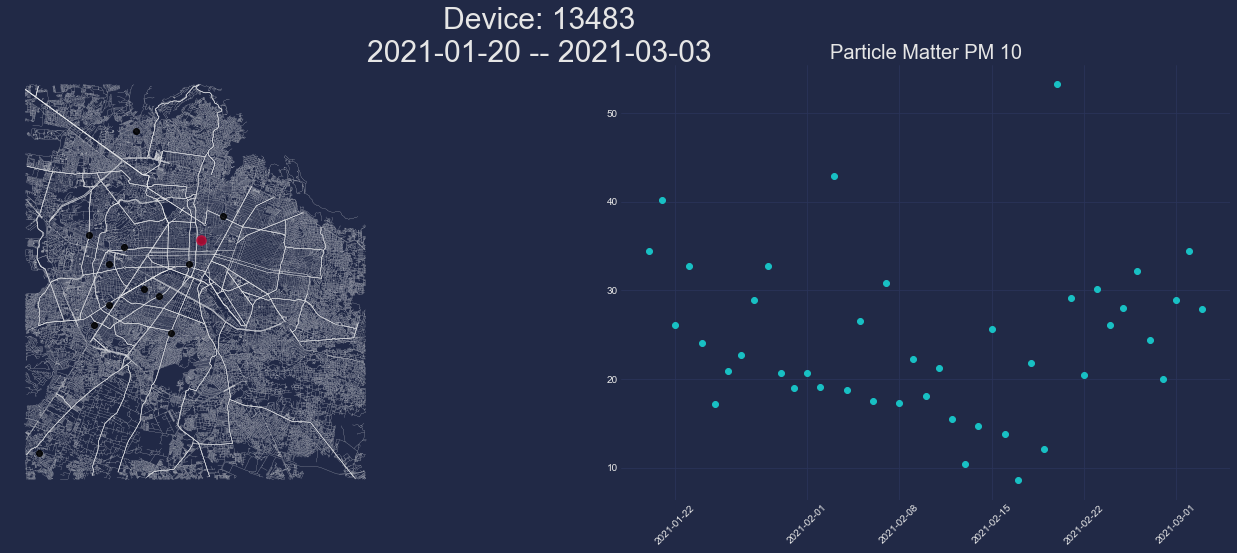

In [ ]:
est = 13483
param = 'Particle Matter PM 10'

graph_smartcitizen(est, param, gdf, gdf_est, edges, save=False)

### Pruebas

Puedes agregar distintos sensores y probar con diferentes parámetros para observar los resultados que se obtienen en cada caso.

Para guardar las figuras resultantes es posible cambiar save a True.

In [ ]:
est = ##
param = '..'

graph_smartcitizen(est, param, gdf, gdf_est, edges, save=False)

## Guardado de datos

Para guardar la base de datos completa se puede utilizar gdf.to_file(), sin embargo, si se hace un filtrado de datos (como el que se muestra en gdf_param) se puede utilizar to_file para guardar solo los datos de interés.

### GeoJSON
Es posible guardar el GeoDataFrame como un geojson, que es un formato de tabla con información espacial, el nombre del archivo lo podemos asignar en la variable name.

In [ ]:
name = '..'

gdf.to_file(f'{name}_GeoDataFrame.geojson',driver='GeoJSON')

### csv
También, es posible guardar el GeoDataFrame como una tabla csv, al igual que en el GeoJSON, el nombre del archivo lo podemos asignar en la variable name.

In [ ]:
name = 'tmp'

gdf.to_csv(f'{name}_.csv')